# <span style="color:orange">Image segmentation - Exercise </span>

<a href="https://colab.research.google.com/github/datarootsio/workshop-image-segmentation-style-transfer/blob/main/notebooks/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this exercise session about image segmentation and style transfer. If you haven't followed the tutorial yet, we recommend that you do the tutorial first before completing this excercise. This is an exercise to get familiar with tool for image segmentation and style transfer. 

<span style="color:red">IMPORTANT INSTRUCTIONS: </span>
Please make a copy of this notebook, upload it into your own google drive.

If you decided to open this notebook without cloning the entire GitHub repository, please make sure to upload all the needed files manually. 

![Maintainer](https://dataroots.io/maintained-rnd.svg)

# **1 Objectives**

The final objective of this exercise is to customize a wall frame that is hanging on the wall in Dataroots' office. To do this, you will have to apply a style of your choice to make the frame more beautiful. However, we do not give you an image containing only the content of the frame to be personalized. Indeed, your original image is a picture of the Dataroots' office. It is up to you to create a model to detect the frame and apply your best style to this object!


In other words, the goal of this exercise session is to learn how to train a new image segmentation model capable of detecting frames on a picture instead of sofas. You might think that all you have to do is change the class of the object to be detected from "sofa" to "frame". Unfortunately, it's not as simple as that. 

## **1.1 Install useful packages**
After the installation of all useful packages that will be used in this exercise session, please restart the runtime to be sure that everything is installed properly.

In [1]:
#@markdown ###Checking for a GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
assert len(device_name) > 0, "No GPU detected. Before installing useful packages, make sure you are using GPU runtime.\nPlease go to Runtime --> Change runtime type --> Choose'GPU' as hardware accelerator"
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#@markdown ###Install the requirements
#@markdown We need to install a specific version for each python packages that will be used in this exercise session. We first pipe all these useful packages into a requirements.txt file before installing them. This step can take several minutes to run.

!pip install pip --upgrade > /dev/null
!printf 'torch==1.13.1+cu116 \ntorchvision==0.14.1+cu116 \npillow==9.0.0 \nscipy==1.9.1 \nnumpy==1.22.4 \ntqdm==4.62.3 \nmatplotlib==3.7.1 \nipympl==0.8.8 \nkeras>=2.8.0rc0 \nsegmentation_models==1.0.1 \nopencv-python-headless==4.5.5.64 \ntensorflow==2.8.0 \ntensorflow_hub==0.12.0 \npycocotools==2.0.6 \ncolormap \neasydev \nh5py==3.1.0' > requirements.txt
!pip install -q --disable-pip-version-check --no-color -r requirements.txt > /dev/null


## **1.2 Connecting to the data and code**

In [3]:
#@markdown ###Connecting to the cloud
#@markdown For ease of access, we have stored the data in the cloud (GCP).  
#@markdown Before being able to access data from a GCP bucket, you first need to login into GCP using the following command. Please follow the instructions!
#@markdown After connecting with your personnal account, you can access the bucket containing the data.

%%capture
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir /content/data_bucket
!gcsfuse --implicit-dirs home_design_bucket /content/data_bucket

In [4]:
#@markdown ###Accessing the data
import os
DATA_DIR = '/content/data_bucket'

x_train_dir = os.path.join(DATA_DIR, 'train_frames/images')
y_train_dir = os.path.join(DATA_DIR, 'train_frames/masks')

x_valid_dir = os.path.join(DATA_DIR, 'validation_frames/images')
y_valid_dir = os.path.join(DATA_DIR, 'validation_frames/masks')

In [5]:
#@markdown ###Downloading the code
!git clone --quiet https://github.com/datarootsio/workshop-image-segmentation-style-transfer.git

# **2 How to create the new dataset set?**

In the tutorial, we used a dataset that had already been sorted. Indeed, all the images contained a sofa since the objective was to detect this object. In this exercise session, the new objective is to detect frames rather than sofas on the same dataset. 

The dataset used contains annotations, which allow us to categorize the objects easily. Let's look at what these annotations look like and whether we can use them to detect frames. 

## 2.1 Load annotations relative to training set

In [6]:
#@markdown The annotations are contained in a file in json format. Let's load the annotation file relative to the training set and observe the categories of objects that can be detected using this dataset. Small reminder: the dataset contains images of indoor virtual spaces.
import os
import json
from pycocotools.coco import COCO
import numpy as np

annotation_file = os.path.join(DATA_DIR, "raw_data/info/categories.json")

with open(annotation_file) as json_data:
        annotations = json.load(json_data)
        cats = annotations["categories"]
        super_categories = np.unique(np.array([cat["super-category"] for cat in cats]))
        print("Main categories of objects that can be detected: \n", super_categories)
        categories = np.unique(np.array([cat["category"] for cat in cats]))
        print("\n Subcategories of objects that can be detected: \n", categories)


Main categories of objects that can be detected: 
 ['Bed' 'Cabinet/Shelf/Desk' 'Chair' 'Lighting' 'Pier/Stool' 'Sofa' 'Table']

 Subcategories of objects that can be detected: 
 ['Barstool' 'Bed Frame' 'Bookcase / jewelry Armoire' 'Bunk Bed'
 'Ceiling Lamp' 'Chaise Longue Sofa' 'Children Cabinet'
 'Classic Chinese Chair' 'Coffee Table' 'Corner/Side Table' 'Desk'
 'Dining Chair' 'Dining Table' 'Drawer Chest / Corner cabinet'
 'Dressing Chair' 'Dressing Table'
 'Footstool / Sofastool / Bed End Stool / Stool' 'Kids Bed'
 'King-size Bed' 'L-shaped Sofa' 'Lazy Sofa'
 'Lounge Chair / Cafe Chair / Office Chair' 'Loveseat Sofa' 'Nightstand'
 'Pendant Lamp' 'Round End Table' 'Shelf'
 'Sideboard / Side Cabinet / Console table' 'Single bed' 'TV Stand'
 'Three-seat / Multi-seat Sofa' 'Wardrobe' 'Wine Cabinet' 'armchair']


We observe that there is no category for frames in the annotations of the dataset we used. We are therefore faced with a major problem: the frames category is not represented in the COCO dataset, so our dataset does not contain labeled examples for frames.

## 2.2 Creating a dataset with frames

In order to train a segmentation model to recognize frames, we need examples. Because there are no examples in the dataset, we will try to create our own.

### Let's try to detect frames using Mask RCNN

In [7]:
#@markdown We saw in the previous section that the "frame" category is not represented in the COCO dataset. In order to verify this information and to visually observe that an object detection model pre-trained on the coco dataset is not able to detect frames, we will try to detect frames using [Mask RCNN](https://github.com/matterport/Mask_RCNN.git).

#@markdown You first have to clone the repository containing the code to run.
%cd /content/
!git clone --quiet https://github.com/BupyeongHealer/Mask_RCNN_tf_2.x.git

# Read in the file
with open('/content/Mask_RCNN_tf_2.x/mrcnn/model.py', 'r') as file :
  filedata = file.read()

# Replace the target string (fix error)
filedata = filedata.replace('KE.Layer', 'KL.Layer')

# Write the file out again
with open('/content/Mask_RCNN_tf_2.x/mrcnn/model.py', 'w') as file:
  file.write(filedata)


/content


/content/Mask_RCNN_tf_2.x


/content/Mask_RCNN_tf_2.x/mrcnn/model.py:2372: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use `tf.cast` instead.


... done downloading pretrained model!


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


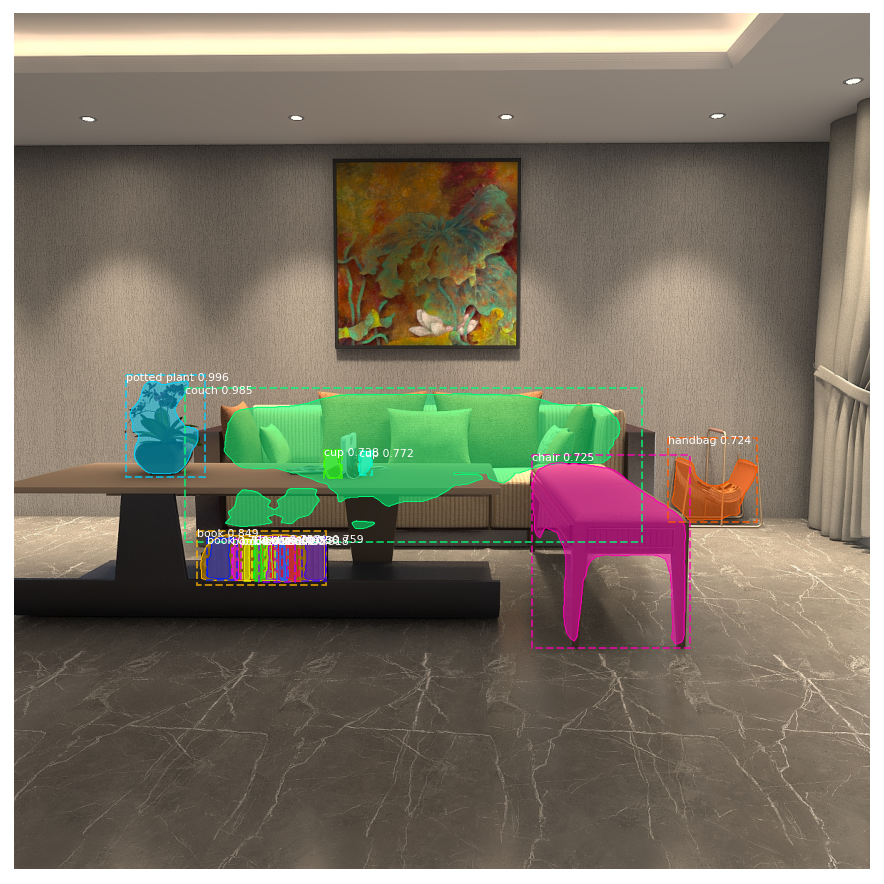

/content


In [8]:
#@markdown Now that we have the code, we can set up the model and load its pre-trained weights.
#@markdown Let's see how well it performs on an image from the dataset

%cd /content/Mask_RCNN_tf_2.x
import urllib.request
import shutil
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
from PIL import Image

#### SET UP THE MODEL AND DOWNLOAD ITS WEIGHTS

def download_trained_weights(coco_model_path, verbose=1):
    """Download COCO trained weights from Releases.

    coco_model_path: local path of COCO trained weights
    """
    COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")



CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
ROOT_DIR = "./"
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    download_trained_weights(COCO_MODEL_PATH)

model.load_weights(filepath=COCO_MODEL_PATH, by_name=True)


### TEST IT ON AN IMAGE OF THE DATASET

# load the input image, convert it from BGR to RGB channel
path_example = os.path.join(os.path.join(DATA_DIR, 'raw_data/train/image'), "0000016.jpg")

image = cv2.imread(path_example)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])
%cd ..

We observe that the model is not able to detect the frame on the image. We must therefore find a way to label the frames in order to train our new image segmentation model.
In the next sections, we will try to find a way to label our data in order to be able to train a ML model afterwards.

### Solution 1: Let's try to create the dataset manually using matplotlib

This package does not seem to be working for you. Here is the result anyway.


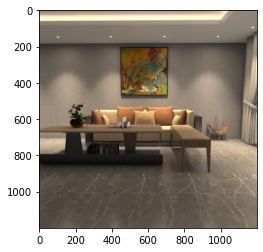

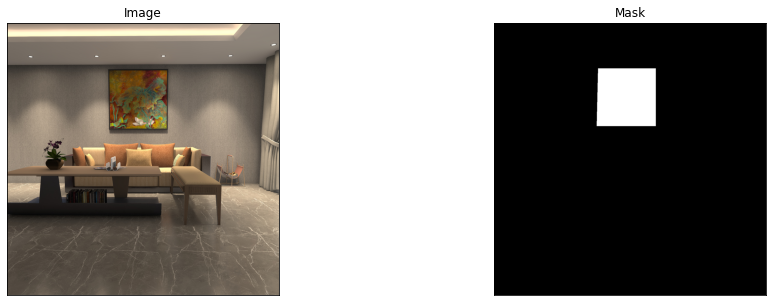

In [11]:
#@markdown The principle is to display an image in an interactive window and to select the corners of the frame manually with the mouse click. The inside of the selected shape will then be filled in with white pixels while the rest of the image will be filled in with black pixels. 

#@markdown **Please wait untill the picture is fully loaded. Rerun if you misclicked.**

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import IPython.display as Disp
from ipywidgets import widgets
from PIL import Image
import numpy as np
import itertools
import cv2
import os
from google.colab import output
output.enable_custom_widget_manager()

def list_files(path_blob):
    images_dir = os.path.join(DATA_DIR, path_blob)
    list_elem = os.listdir(images_dir) 
    number_files = len(list_elem)
    print(f"Number of files in the {path_blob} folder: {number_files}")
    return list_elem, number_files


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()


class bbox_select():

    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im)
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def poly_img(self, img, pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),2)
        return img

    def onclick(self, event):
        if event.xdata is None or event.ydata is None: 
          return
        print("Clicked")
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            pts = np.array(self.selected_points, np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.polylines(self.im.copy(),[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),3)
        if len(self.selected_points)==4: 
            print("Collected all four points, result:")
            self.fig.canvas.mpl_disconnect(self.ka)
            plt.close(self.fig)
            self.show_result()

    def show_result(self, selected_points):
      %matplotlib inline
      arr = np.array([self.selected_points],'int')
      mask = cv2.fillPoly(np.zeros(im.shape, np.uint8), pts=arr, color=[255, 255, 255])
      visualize(
          image=im,
          mask=mask
      )

path_image = os.path.join(os.path.join(DATA_DIR, 'raw_data/train/image'), "0000016.jpg")
im = plt.imread(path_image)

try:
  %matplotlib ipympl
  bs = bbox_select(im)
  bs.show_result(bs.selected_points)
except:
  %matplotlib inline
  print("This package does not seem to be working for you. Here is the result anyway.")
  bs = bbox_select(im)
  bs.selected_points = [[459.32339955849886, 200.6037527593819], [453.80463576158934, 454.4668874172186], [713.1865342163354, 454.4668874172186], [713.1865342163354, 200.6037527593819]]
  bs.show_result(bs.selected_points)

### Solution 2: Let's try to create the dataset manually using idmap images

In this solution, we will try to find the mask of an object on an image according to the idmap of this image. Indeed, by indicating which colours represent the mask in the idmap, it is very easy to construct the mask.

Number of files in the raw_data/train/image folder: 14761
Number of files in the raw_data/train/idmap folder: 14761


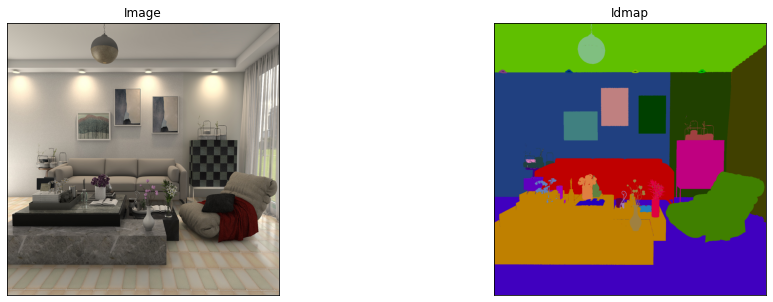

In [9]:
#@markdown Let's first have a look at the original image and the corresponding idmap.

#@markdown In order to identify the frames on the picture, we will identify which color is representing a frame on the picture. In this case, you see 3 different frames represented by 3 different colors: 
#@markdown - light blue
#@markdown - light pink
#@markdown - dark green

%matplotlib inline
from PIL import Image
import numpy as np
import os
from typing import List
import pandas as pd
from colormap import rgb2hex

path_blob_images = 'raw_data/train/image'
path_blob_idmap = 'raw_data/train/idmap'
list_images, _ = list_files(path_blob=path_blob_images)
list_idmap, _ = list_files(path_blob=path_blob_idmap)
count = 0

image_dir = os.path.join(DATA_DIR, path_blob_images)
idmap_dir = os.path.join(DATA_DIR, path_blob_idmap)

index = 49
path_image = list_images[index]
path_idmap = list_idmap[index]

img = Image.open(os.path.join(image_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

visualize(
    image=img, 
    idmap=idmap
)

def from_rgb_to_hex(rgb_colors):
    hex_colors = []
    for (occurences, rgb) in rgb_colors:
      hex_colors.append([rgb2hex(rgb[0], rgb[1], rgb[2]), rgb, occurences])
    return hex_colors


def row_style(row):
    color_to_apply = row.hex
    return pd.Series(f'background-color: {color_to_apply}', row.index)


def display_hex_colors(hex_colors):
    """Visualize a list of hex colors using pandas"""
    df = pd.DataFrame(hex_colors)
    df.columns = ["hex", "rgb", "occurences"]
    df = df[df.occurences > 7000].reset_index()
    hex = list(df["hex"])
    df = df.style.apply(row_style, axis=1)
    display(df)

hex_colors = from_rgb_to_hex(idmap.getcolors())
display_hex_colors(hex_colors)

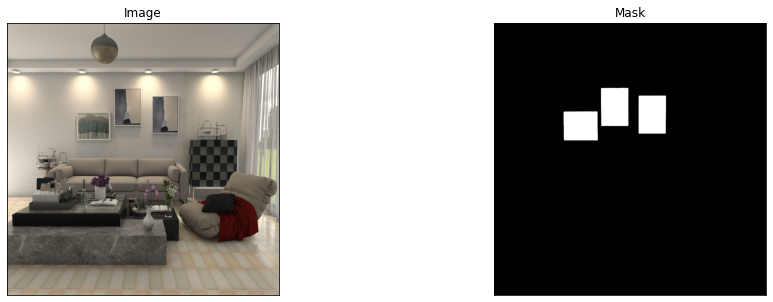

In [10]:
#@markdown Now that we found these colors, we can generate the binary mask. In other words, we will create a black picture on which we will highlight some white pixels. These pixels will be the frames.
def modify_pixels(image, pixels):

  width, height = image.size

  # Process every pixel
  for x in range(width):
    for y in range(height):
        current_color = image.getpixel( (x,y) )
        if current_color not in pixels:
          new_color = (0, 0, 0)
        else:
          new_color = (255, 255, 255)
        image.putpixel((x,y), new_color)
  
  return image

idmap_mask = modify_pixels(idmap, [(0, 64, 0), (64, 128, 128), (191, 128, 128)])
visualize(
    image=img, 
    mask=idmap_mask
)

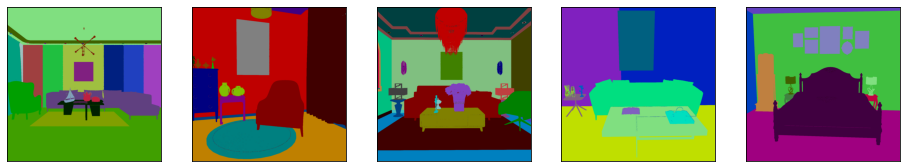

In [12]:
#@markdown Detecting the frame masks by manually finding the idmap colors representing the frames works but it is not very optimal to do this for thousands of images. Let's try to find a pattern to automate this color detection. In other words, the question is: can we find some clusters of colors that are typically used for frames?

#@markdown Let's visualise some images to see. Unfortunately, the colors are note chosen consistently. We also did a cluster analysis on the colors, but to no avail.
n=5
indices = [5167, 4956, 6268, 7097, 13169] #np.random.choice(range(len(list_idmap)),size=n)
plt.figure(figsize=(16, 5))
for i,index in enumerate(indices):
  path_idmap = list_idmap[index]
  idmap = Image.open(os.path.join(idmap_dir, path_idmap))
  plt.subplot(1, n, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(idmap)

### Solution 3: Let's try to create the data set automatically using OpenCV

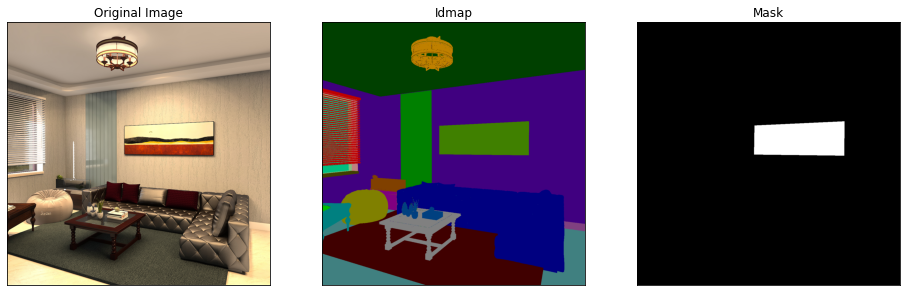

In [11]:
#@markdown This last solution is the one that has been used to create the dataset that will be given as input of the image segmentation model. The goal of this solution is to use OpenCV to detect frames automatically. Indeed, frames have some characteristics that can be easily recognized:
#@markdown - 4 edges 
#@markdown - Rectangle 
#@markdown - More than 4000 pixels

#@markdown [OpenCV](https://opencv.org/about/) is a well-known open-source computer vision library that you can use very easily. 

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

set_type = "raw_data/train"
images_dir = os.path.join(DATA_DIR, set_type + '/image')
idmap_dir = os.path.join(DATA_DIR, set_type + '/idmap')
list_elem = os.listdir(images_dir) 
number_files = len(list_elem)
list_idmap = os.listdir(idmap_dir) 
number_files = len(list_idmap)

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()


def find_mask(img):
    count = 0
    new_img = np.zeros(img.shape).astype(img.dtype)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img,100,200)
    kernal = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(edges, kernal , iterations=2)
    bilateral = cv2.bilateralFilter(dilation,9,75,75)
    contours, hireracy = cv2.findContours(bilateral,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for i,contour in enumerate(contours):
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour,True),True)   
        if len(approx) == 4:

            X,Y,W,H = cv2.boundingRect(approx)
            area = cv2.contourArea(contour)

            # Keep only rectangles of more than 4000 pixels to avoid very small ones
            if area > 4000 :
                count += 1
                box = cv2.rectangle(img, (X,Y), (X+W,Y+H), (0,0,255), 2)
                cropped = img[Y: Y+H, X: X+W]
                cv2.drawContours(new_img, [approx], 0, (255,255,255),1)
                cv2.fillPoly(new_img, pts =[approx], color=(255,255,255))

    return new_img, count

index = 4

path_image = list_elem[index]
path_idmap = list_idmap[index]

original_img = Image.open(os.path.join(images_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

img, count = find_mask(np.asarray(idmap))
visualize(
    original_image=original_img,
    idmap=idmap,
    mask=img
)

# **3 Train the new image segmentation model**

In [ ]:
#@markdown In this section, we will train a new image segmentation model using the data that was created in the previous section. The goal is to build an image segmentation model capable of detecting frames on a picture and creating a mask of these frames.
import os
if os.getcwd()!="/content": os.chdir("/content") 

!pip install -q segmentation-models > /dev/null
!apt install -q --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 > /dev/null

restart = "True" #@param {type: str} ["True","False"]
if restart == "True":
  os.kill(os.getpid(), 9)

In [1]:
#@markdown ###Load data
%%capture
from google.colab import auth
import os
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir /content/data_bucket
!gcsfuse --implicit-dirs home_design_bucket /content/data_bucket

if not os.path.exists("/content/workshop-image-segmentation-style-transfer"):
  !git clone --quiet https://github.com/datarootsio/workshop-image-segmentation-style-transfer.git

import os
DATA_DIR = '/content/data_bucket'

x_train_dir = os.path.join(DATA_DIR, 'train_frames/images')
y_train_dir = os.path.join(DATA_DIR, 'train_frames/masks')

x_valid_dir = os.path.join(DATA_DIR, 'validation_frames/images')
y_valid_dir = os.path.join(DATA_DIR, 'validation_frames/masks')

## 3.1 Create and compile the image segmentation model

In [2]:
#@markdown In this section, we will define the image segmentation model and compile it so that it's ready to be trained. Note that the building and compilation of the model is done on the GPU device in order to be able to train this model using the GPU later. 

#@markdown Feel free to modify anything you want. 

#import packages
import os
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#import segmentation-models package and set framework to tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

# Set parameters
BACKBONE = 'efficientnetb0' #@param ['efficientnetb0','vgg16','resnet18','mobilenet']{type:"string"}
CLASSES = ['wall_frame'] #@param
n_classes = len(CLASSES) + (len(CLASSES)>1)

IMG_SIZE = 224 #@param {type:"integer"}
BATCH_SIZE = 2 #@param {type:"integer"}
LR = 0.0001 #@param {type:"number"}
EPOCHS = 40 #@param {type:"integer"}
activation = 'sigmoid' if n_classes == 1 else 'softmax'

device_name = tf.test.gpu_device_name()
#create image segmentation model
with tf.device(device_name):
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

  # define optomizer
  optim = tf.keras.optimizers.Adam(LR)

  # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)

  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)

callbacks = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    ReduceLROnPlateau(),
    EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=10)
  ]

Segmentation Models: using `keras` framework.
16818176/16804768 [==============================] - 0s 0us/step


## 3.2 Create the new training dataset

Now that we found a way to create a new training dataset, we can use this data to train a new image segmentation model

In [3]:
#@markdown ###Create a training and validation set
#@markdown These datasets will then be given as input of the training of the model. 
#@markdown The trainingset is used for training, the validation set is used to finetune the hyperparameters.
import tensorflow as tf

#### USEFUL FUNCTIONS

def read_img(image, mask):
  '''Read, decode into array, resize and rescale images and masks'''

  im = tf.io.read_file(image)
  im = tf.image.decode_jpeg(im, channels = 3)
  im = tf.image.resize(im, [IMG_SIZE,IMG_SIZE])
  im = im/255
  
  msk = tf.io.read_file(mask)
  msk = tf.image.decode_jpeg(msk, channels=3)
  msk = tf.image.resize(msk, [IMG_SIZE,IMG_SIZE])
  msk = tf.cast((msk==255),float)
  
  return im, msk


# helper function for data visualization 
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


#### CREATE DATAFRAMES
train_df = pd.DataFrame()
train_df['image'] = [os.path.join(x_train_dir, file) for file in os.listdir(x_train_dir)]
train_df['mask'] = [os.path.join(y_train_dir, file).replace('.jpg', '.png') for file in os.listdir(x_train_dir)]

test_df = pd.DataFrame()
test_df['image'] = [os.path.join(x_valid_dir, file) for file in os.listdir(x_valid_dir)]
test_df['mask'] = [os.path.join(y_valid_dir, file).replace('.jpg', '.png') for file in os.listdir(x_valid_dir)]

print(f"Number of training samples: {len(train_df)} \nNumber of validation samples: {len(test_df)}")

Number of training samples: 2796 
Number of validation samples: 1052


In [6]:
#@markdown ### Check if a mask is present for each image
#@markdown In the training and validation set, we have to make sure that all images also have a corresponding mask, otherwise it will not be possible to use this sample to train the model.

def check_image_mask(x_train_dir, y_train_dir, df):
  xtrain_paths = os.listdir(x_train_dir)
  ytrain_paths = os.listdir(y_train_dir)
  ytrain_paths = [x.replace('.png','.jpg') for x in ytrain_paths]
  rmlist = [p.split('.')[0] for p in xtrain_paths if p not in ytrain_paths]
  rmindex = []
  for i in rmlist:
    rmindex += [x for x, y in zip(df.index, df['image']) if i in y]
  df.drop(rmindex,axis=0,inplace=True)
  return df

train_df = check_image_mask(x_train_dir, y_train_dir, train_df)
test_df = check_image_mask(x_train_dir, y_train_dir, test_df)

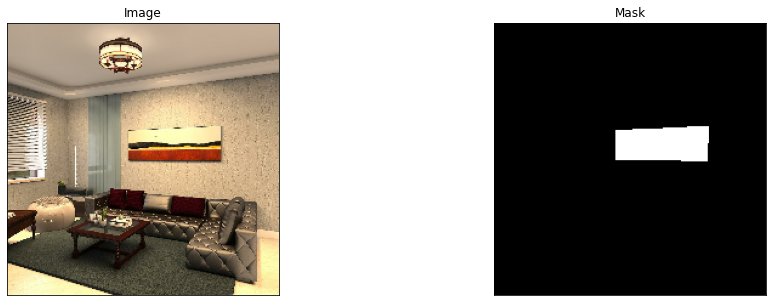

In [7]:
#@markdown ###Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['mask']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['mask']))

train = train_ds.map(read_img)
test_unbatch = test_ds.map(read_img)

eximage, exmask = list(train.shuffle(10).take(1).as_numpy_iterator())[0]

visualize(
    image = eximage,
    mask = exmask
)

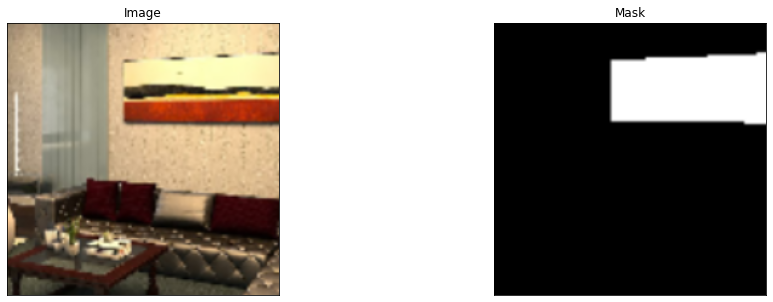

In [8]:
#@markdown ###Data augmentation
#@markdown To make the model robust and avoid overfitting, we add noise to the training data by applying data augmentation methods.

def augment_image(image, mask):
  seed_value = 1998
  size = image.shape
  crop_ratio = .7
  im = tf.image.random_flip_left_right(image, seed=seed_value)
  msk = tf.image.random_flip_left_right(mask, seed=seed_value)
  im = tf.image.random_crop(im, size = [round(size[0]*.7),round(size[1]*.7),3], seed=seed_value)
  msk = tf.image.random_crop(msk, size = [round(size[0]*.7),round(size[1]*.7),3], seed=seed_value)
  im = tf.image.resize(im, size[:2])
  msk = tf.image.resize(msk, size[:2])
  return im, msk

train = train.map(augment_image)
foo = train.take(10).map(augment_image)
eximage2, exmask2 = list(foo.shuffle(10).take(1).as_numpy_iterator())[0] 
visualize(image=eximage2, mask = exmask2)

In [9]:
#@markdown ###Transform data in to batches
#@markdown The last step before being able to train the model is to transform data into batches.
train = train.batch(BATCH_SIZE)
test = test_unbatch.batch(BATCH_SIZE)

## 3.3 Train the model 

In [ ]:
#@markdown It's time to train the model! 

#@markdown Haha no, not really. It takes approximately 10 minutes to run each epoch on the GPU device. We don't have time to train the model, you can skip this cell and use the model that was already trained previously. 

# history = model.fit(
#     train, 
#     validation_data=test, 
#     epochs=EPOCHS, 
#     callbacks=callbacks
# )

## 3.4 Check if the model performs well on a test data

--2023-03-22 20:35:23--  https://storage.googleapis.com/home_design_bucket/models/best_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41070592 (39M) [application/octet-stream]
Saving to: ‘best_model.h5’

best_model.h5       100%[===================>]  39.17M  20.3MB/s    in 1.9s    

2023-03-22 20:35:26 (20.3 MB/s) - ‘best_model.h5’ saved [41070592/41070592]

526/526 [==============================] - 495s 928ms/step - loss: 0.0902 - iou_score: 0.8808 - f1-score: 0.9256
Loss: 0.090175


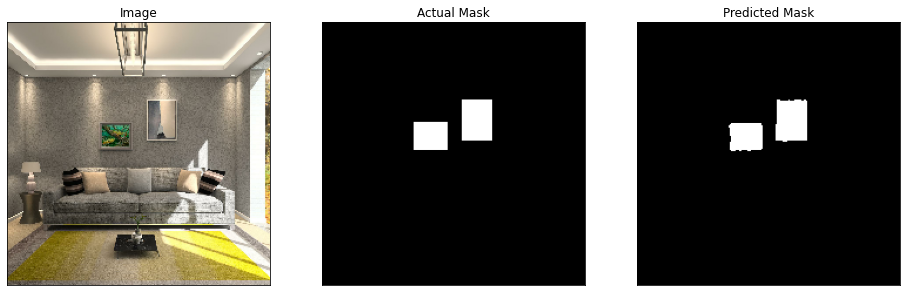

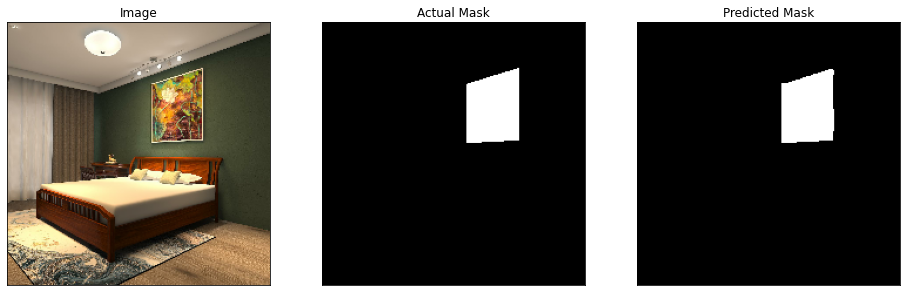

In [10]:
#@markdown In order to evaluate the performance of the model that we trained in the previous section, we will use an unseen image and try to predict the mask of the frame on this image.

#@markdown The following cell loads the model that was trained in the previous section and evaluates its performance on the test set.
#@markdown We will also predict the mask for a randomly chosen test image.

#@markdown **This may take a few minutes to run (approximately 10). If you don't want to wait, just skip this cell.**

import matplotlib.pyplot as plt
import cv2 
import numpy as np

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

!wget -O best_model.h5 'https://storage.googleapis.com/home_design_bucket/models/best_model.h5'

# Evaluate model performance on "test" set
model.load_weights("best_model.h5")
scores = model.evaluate(test)
print("Loss: {:.5}".format(scores[0]))

test_show = list(test_unbatch.take(3).as_numpy_iterator())

for i in range(2):
  eximage, exmask = test_show[i]
  image = eximage
  gt_mask = exmask
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()

  visualize(
      image = image.squeeze(),
      actual_mask=gt_mask.squeeze(),
      predicted_mask=pr_mask.squeeze()
  )

# <span style="color:orange">Style transfer - Exercise </span>

In the previous chapter, you learnt how to create and train an image segmentation model in order to detect frames on a picture. The goal of this second chapter of the exercise session is to learn how to apply a new style to the frame that you detected previously. 

It's time to show your creativity!


# 1 Choose the image to customize

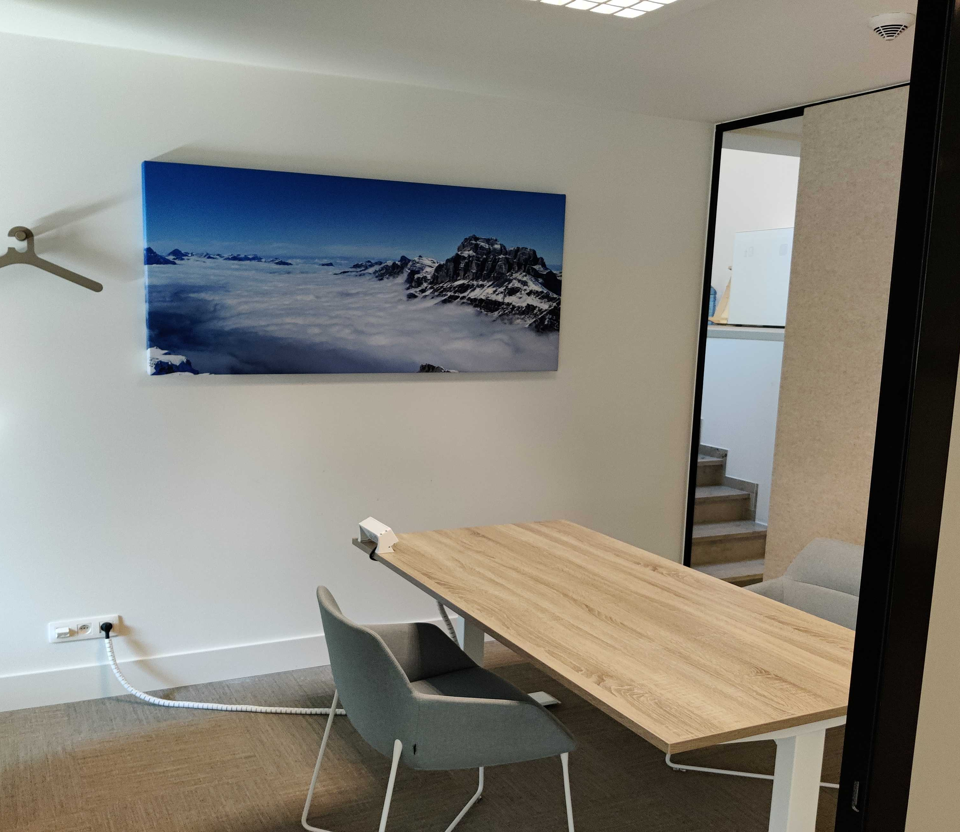

In [23]:
#@markdown The image to be customized shows a meeting room at the dataroots office. This image was stored in GCP so that you can access it easily. 

#@markdown If you don't like it you can upload your own image (with a frame) by selecting "custom".

#@markdown **This option does not work in Safari, please switch to chrome if you want to use a custom image.**

from PIL import Image
import os
import numpy as np
from IPython.display import display
from google.colab import files

def upload_files():
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

image = "default" #@param {type: str} ["default","custom"]
if image == "default":
  image_to_custom = os.path.join(DATA_DIR, 'styles/image_to_custom.jpg')
else: 
  image_to_custom = upload_files()[0]

image_to_custom = os.path.join(DATA_DIR, 'styles/image_to_custom.jpg')

img = Image.open(image_to_custom)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (960, 832)
new_img = img.crop((left, top, right, bottom))
new_img = new_img.resize(newsize)

new_img.save(f"image_to_custom.jpg")
display(new_img)

# 2 Choose the pattern to apply to the image

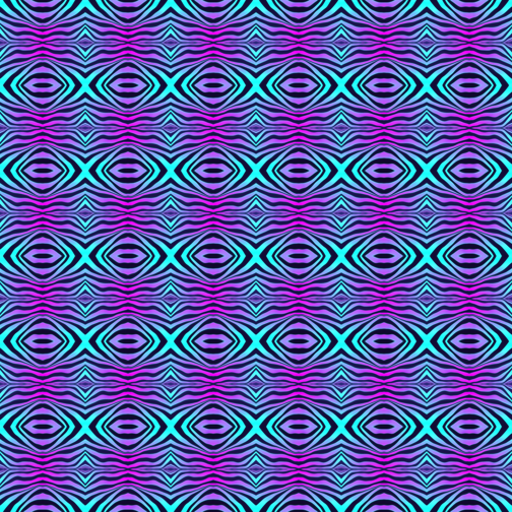

In [14]:
#@markdown It's now time to choose the pattern that you want to apply to the frame. You can either load a pattern that is already stored in Azure (5 possibilites) or you can upload your own pattern locally.

# Get style example from Azure or upload your own
import os
from PIL import Image
from IPython.display import display
import numpy as np

styles = {
    "multi-color": "styles/multicolor_pattern.jpeg",
    "tiger": "styles/tiger_pattern.jpeg",
    "water": "styles/water_pattern.jpeg",
    "zebra": "styles/zebra_pattern.jpeg",
    "zebra-color": "styles/zebra_color_pattern.jpeg"
}

pattern = "zebra-color" #@param {type:str} ["multi-color","tiger","water","zebra","zebra-color","custom"]
if pattern in styles.keys():
  style_path = os.path.join(DATA_DIR, styles[pattern])
else: 
  style_path = upload_files()[0]
img = Image.open(style_path)
img.save(f"{pattern}.jpg")


# Resize the pattern to the approriate heigth and width
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (512, 512)
im1 = img.crop((left, top, right, bottom))
im1 = im1.resize(newsize)

# Customize the pattern 
#@markdown We will copy it multiple times to create a pattern.
copies = 12 #@param {type:"slider", min:0, max:20, step:2}
if copies > 0:
  resize = (newsize[0]//copies,newsize[1]//copies)
  dst = Image.new('RGB', (resize[0]*copies,resize[1]*copies))
  im2 = im1.resize((resize))
  for row in range(copies):
    im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
    for column in range(copies):
      im2 = im2.transpose(Image.FLIP_TOP_BOTTOM)
      dst.paste(im2, (resize[0]*row, resize[1]*column))
  dst = dst.resize((newsize))
  dst.save('./style_customized.jpg')
  display(dst)
else: 
  display(im1)

# 3 Apply the pattern on the entire image

In [21]:
#@markdown ### Create the environment to apply the style transfer if not yet installed

!pip install -q virtualenv > /dev/null
if not os.path.exists("/content/styletransformer"):
  !virtualenv styletransformer > /dev/null
!source /content/styletransformer/bin/activate; pip install -q torch==1.7.1 torchvision==0.8.2 scipy==1.9.1 matplotlib==3.3.3 ipympl==0.8.8 > /dev/null

/content
image_to_custom.jpg
<class 'int'>
/content/styletransformer/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


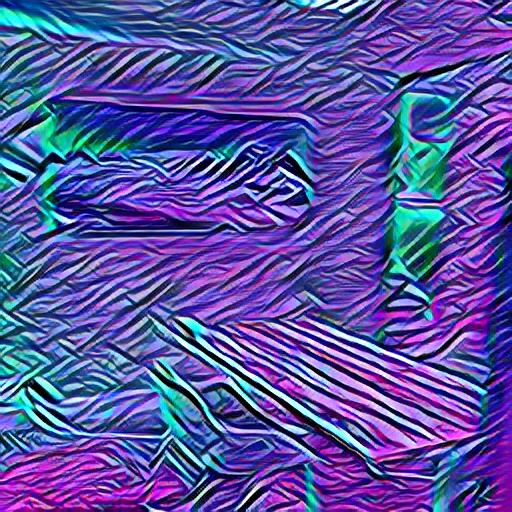

In [9]:
#@markdown The goal of this section is to apply the pattern to the entire picture.
#@markdown Let's give the image and the pattern to the style transformer and see what it comes up with.

#@markdown **This may take a minute...**
%cd /content/

if not os.path.exists("/content/StyTR-2"):
  !git clone --quiet https://github.com/diyiiyiii/StyTR-2.git > /dev/null
  # fix an error in one of the files of the github repo
  !mv workshop-image-segmentation-style-transfer/scripts/apply_pattern.py StyTR-2/ > /dev/null 

# Get pre-trained model from the cloud
import os 
vgg_path = os.path.join(DATA_DIR, "models/vgg_normalised.pth")
decoder_path = os.path.join(DATA_DIR, "models/decoder_iter_160000.pth")
transformer_path = os.path.join(DATA_DIR, "models/transformer_iter_160000.pth")
embedding_path = os.path.join(DATA_DIR, "models/embedding_iter_160000.pth")
uploaded_image = "image_to_custom.jpg"

# style the image
!source /content/styletransformer/bin/activate; python StyTR-2/apply_pattern.py  --content $uploaded_image \
                  --style style_customized.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

# Let's look at the styled image
from IPython.display import Image, display
path_styled_image = uploaded_image.split(".")[0] + "_stylized_style_customized.jpg"
display(Image(filename=path_styled_image))

from PIL import Image as Img
Img.open(path_styled_image).resize((width, height)).save(path_styled_image)


# 4 Get final customized image

This is the final step of this exercise session. The goal is to get the final customized image. To get this, you will need to apply the style only to the frame we want to custom instead of applying it to the full picture.

--2023-03-22 20:59:06--  https://storage.googleapis.com/home_design_bucket/models/best_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41070592 (39M) [application/octet-stream]
Saving to: ‘best_model.h5’

best_model.h5       100%[===================>]  39.17M  20.4MB/s    in 1.9s    

2023-03-22 20:59:08 (20.4 MB/s) - ‘best_model.h5’ saved [41070592/41070592]

Get actual mask from the cloud


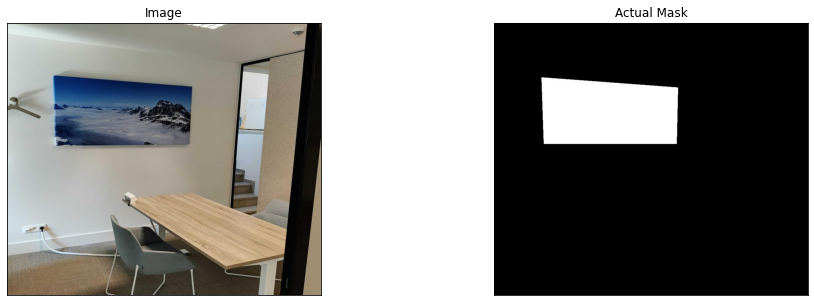

In [17]:
#@markdown ### Predict the mask or get it from GCP 
#@markdown In the previous chapter, you could train an image segmentation model. 
#@markdown We disabled that part of the code to avoid having to wait too long for the model to train.
#@markdown But don't worry! You can load a previously rendered mask of the default frame from GCP. 
import matplotlib.pyplot as plt
import segmentation_models as sm
import tensorflow as tf
import keras

sm.set_framework('tf.keras')
device_name = tf.test.gpu_device_name()

# helper function for data visualization 
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
uploaded_image = "image_to_custom.jpg"
from PIL import Image

!wget -O best_model.h5 'https://storage.googleapis.com/home_design_bucket/models/best_model.h5'

with tf.device(device_name):
  model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
  optim = tf.keras.optimizers.Adam(0.0001)
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(optim, total_loss, metrics)

if image != "default":
  print("Predicting mask")
  
  IMG_SIZE = 224
  img = tf.io.read_file(uploaded_image)
  img = tf.image.decode_jpeg(img, channels = 3)
  img_tf = tf.image.resize(img, [IMG_SIZE,IMG_SIZE])
  img_tf = img_tf/255
  img_tf = np.expand_dims(img_tf, axis=0)

  model.load_weights("best_model.h5")
  pred_mask = model.predict(img_tf).round()

  formatted = (pred_mask.squeeze() * 255 / np.max(pred_mask.squeeze())).astype('uint8')
  pred_mask_to_save = Image.fromarray(formatted).resize((width,height))
  visualize(
      original_image = img,
      predicted_mask=pred_mask.squeeze()
  )
  pred_mask_to_save.save('mask.jpg')

else:
  print("Get actual mask from the cloud")
  actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
  original_img = Image.open(uploaded_image)

  mask = Image.open(actual_mask)
  visualize(
          image=original_img,
          actual_mask=mask
  )

  mask.save("mask.jpg")


<ipython-input-18-c65fe697f753>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  generated_image = imageio.imread(generated_image, pilmode="RGB")
<ipython-input-18-c65fe697f753>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  content_image = imageio.imread(content_image, pilmode='RGB')
<ipython-input-18-c65fe697f753>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imagei

Image saved at path : image_to_custom_stylized_style_customized_masked.png


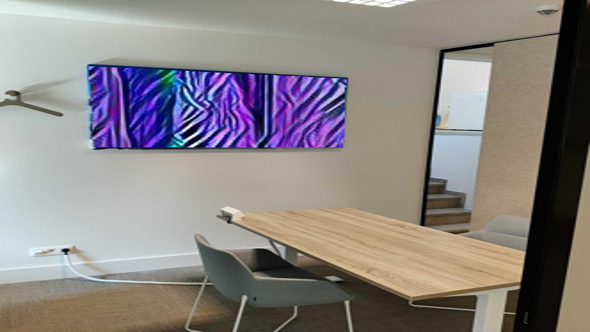

In [18]:
#@markdown ### Apply style only on the chosen object
#@markdown The last step of this exercise session is to apply the new style only on the wallframe and not on the entire picture using the mask determined in the previous section.
content_image = "image_to_custom.jpg"
generated_image = "image_to_custom_stylized_style_customized.jpg"
content_mask = "mask.jpg"

import os
import numpy as np
import imageio
from PIL import Image as Img
from PIL import ImageTk

# util function to load masks
def load_mask(mask_path, shape):
    mask = imageio.imread(mask_path, pilmode="L") # Grayscale mask load
    width, height, _ = shape
    mask = np.array(Img.fromarray(mask).resize((width, height))).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask

# util function to apply mask to generated image
def mask_content(content, generated, mask):
    generated = np.transpose(generated, (1, 0, 2))
    height, width, channels = generated.shape

    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    generated = np.array(Img.fromarray(generated).resize((content.shape[0], content.shape[1])))
    return generated
  
# util function to generate the final masked image
def save_final_masked(content_image, generated_image, content_mask):
  image_path = os.path.splitext(generated_image)[0] + "_masked.png"

  generated_image = imageio.imread(generated_image, pilmode="RGB")
  img_width, img_height, channels = generated_image.shape

  content_image = imageio.imread(content_image, pilmode='RGB')
  content_image = np.array(Img.fromarray(content_image).resize((img_width, img_height)))

  mask = load_mask(content_mask, generated_image.shape)

  img = mask_content(content_image, generated_image, mask)
  imageio.imwrite(image_path, img)

  return image_path

save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

# Let's look at the final styled image
from IPython.display import Image, display
display(Image(filename="image_to_custom_stylized_style_customized_masked.png"))

**Satisfied with your customization? Upload your final picture on [GCP](https://console.cloud.google.com/storage/browser/home_design_bucket/results?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&project=bootcamp-227610&prefix=&forceOnObjectsSortingFiltering=false) in the "results" folder!**

Note: The name of your file should contain your firstname and lastname. You can also upload the picture you used to build this amazing customization!

# <span style="color:orange">Style transfer with stable diffusion - Exercise </span>

In the previous chapter, you learnt how to create and train an image segmentation model in order to detect frames on a picture. The goal of this second chapter of the exercise session is to learn how to apply a new style to the frame that you detected previously. 

It's time to show your creativity!

# 1 Choose the image to customize

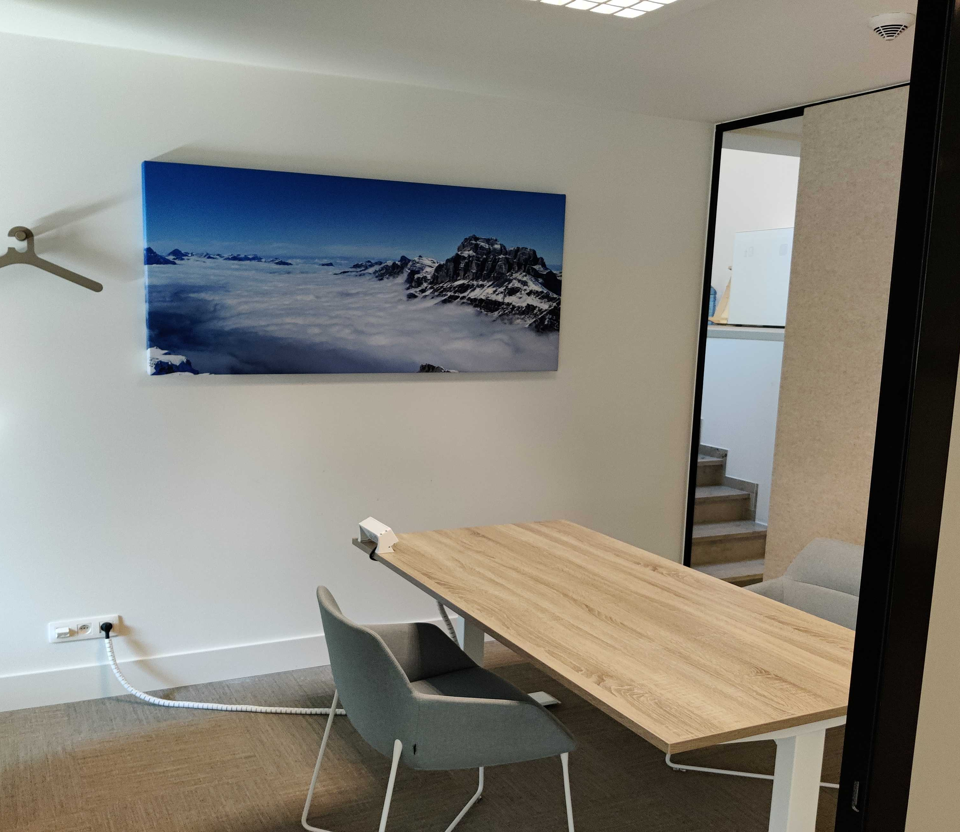

In [4]:
#@markdown The image to be customized shows a meeting room at the dataroots office. This image was stored in GCP so that you can access it easily. 

#@markdown If you don't like it you can upload your own image (with a frame) by selecting "custom".

#@markdown **This option does not work in Safari, please switch to chrome if you want to use a custom image.**

from PIL import Image
import os
import numpy as np
from IPython.display import display
from google.colab import files

def upload_files():
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

image = "default" #@param {type: str} ["default","custom"]
if image == "default":
  image_to_custom = os.path.join(DATA_DIR, 'styles/image_to_custom.jpg')
else: 
  image_to_custom = upload_files()[0]

image_to_custom = os.path.join(DATA_DIR, 'styles/image_to_custom.jpg')

img = Image.open(image_to_custom)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (960, 832)
new_img = img.crop((left, top, right, bottom))
new_img = new_img.resize(newsize)

new_img.save(f"image_to_custom.jpg")
display(new_img)

# 2 Apply a new pattern on the entire image using stable diffusion

In [5]:
#@markdown ### Installing some packages in order to use the stable diffusion model

!pip install -qqq git+https://github.com/huggingface/diffusers.git transformers accelerate safetensors > /dev/null

In [6]:
#@markdown ### Loading the stable diffusion model

#@markdown Now that all packages are installed, it's time to load the stable diffusion model from Hugging Face

import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", safety_checker=None)
pipe.to("cuda")
pipe.enable_attention_slicing()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

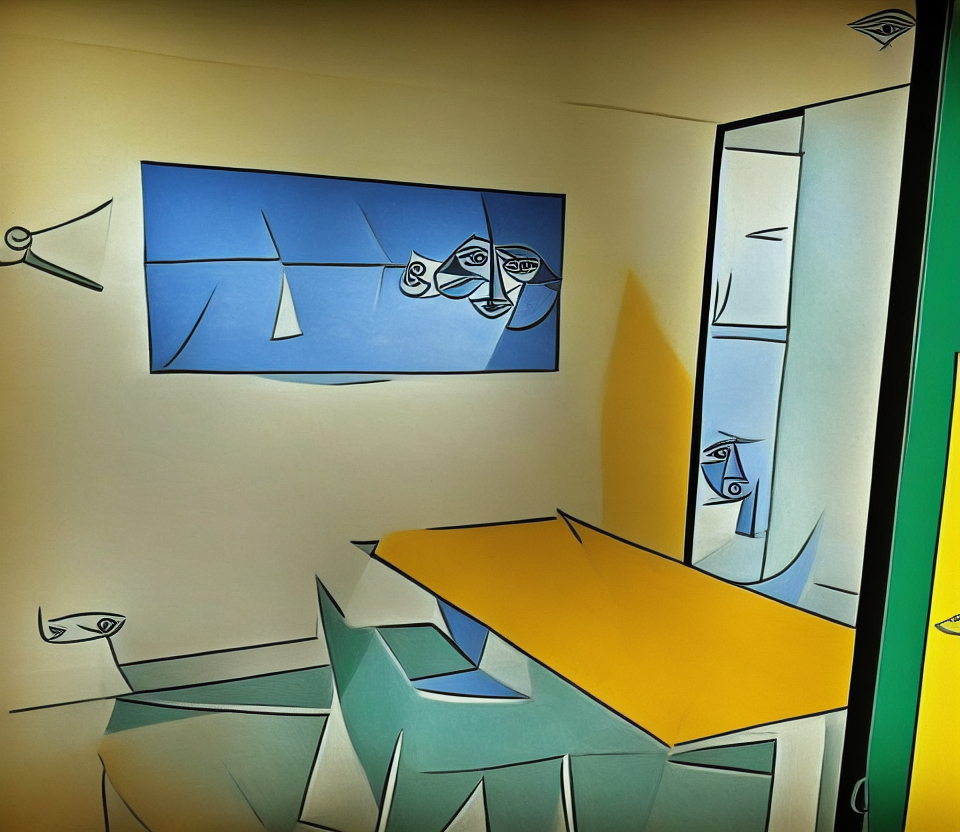

In [7]:
#@markdown ### Create the new image! 

#@markdown It's time for you to show your creativity, feel free to give an instruction that will apply a new style to the image. Be creative! 

import random
import math
from PIL import Image, ImageOps

image = Image.open("./image_to_custom.jpg")
image = ImageOps.exif_transpose(image)
image = image.convert("RGB")

instruction = "Make the painting in the style of Picasso" #@param
sylized_image = pipe(instruction, image=image, num_inference_steps=20, image_guidance_scale=1).images[0]
sylized_image.save(f"image_to_custom_stylized_style_customized.jpg")
sylized_image

# 3 Get final customized image

This is the final step of this exercise session. The goal is to get the final customized image. To get this, you will need to apply the style only to the frame we want to custom instead of applying it to the full picture.

--2023-03-23 11:39:25--  https://storage.googleapis.com/home_design_bucket/models/best_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41070592 (39M) [application/octet-stream]
Saving to: ‘best_model.h5’

best_model.h5       100%[===================>]  39.17M  24.6MB/s    in 1.6s    

2023-03-23 11:39:27 (24.6 MB/s) - ‘best_model.h5’ saved [41070592/41070592]

Predicting mask


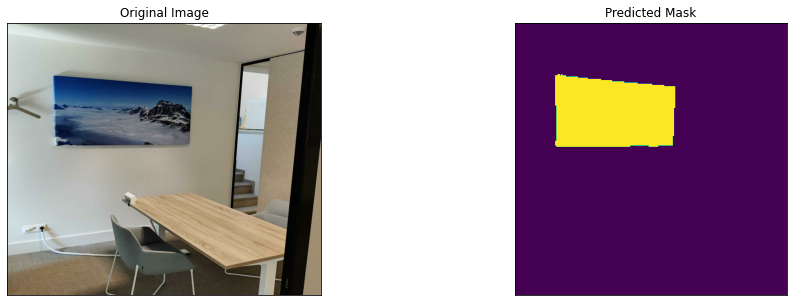

In [8]:
#@markdown ### Predict the mask or get it from GCP 
#@markdown In the previous chapter, you could train an image segmentation model. 
#@markdown We disabled that part of the code to avoid having to wait too long for the model to train.
#@markdown But don't worry! You can load a previously rendered mask of the default frame from GCP. 
import matplotlib.pyplot as plt
import segmentation_models as sm

# helper function for data visualization 
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
uploaded_image = "image_to_custom.jpg"
from PIL import Image

!wget -O best_model.h5 'https://storage.googleapis.com/home_design_bucket/models/best_model.h5'

with tf.device(device_name):
  model = sm.Unet('efficientnetb0', classes=1, activation='sigmoid')
  optim = tf.keras.optimizers.Adam(0.0001)
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(optim, total_loss, metrics)

if image != "default":
  print("Predicting mask")
  
  IMG_SIZE = 224
  img = tf.io.read_file(uploaded_image)
  img = tf.image.decode_jpeg(img, channels = 3)
  img_tf = tf.image.resize(img, [IMG_SIZE,IMG_SIZE])
  img_tf = img_tf/255
  img_tf = np.expand_dims(img_tf, axis=0)

  model.load_weights("best_model.h5")
  pred_mask = model.predict(img_tf).round()

  formatted = (pred_mask.squeeze() * 255 / np.max(pred_mask.squeeze())).astype('uint8')
  pred_mask_to_save = Image.fromarray(formatted).resize((width,height))
  visualize(
      original_image = img,
      predicted_mask=pred_mask.squeeze()
  )
  pred_mask_to_save.save('mask.jpg')

else:
  print("Get actual mask from the cloud")
  actual_mask = os.path.join(DATA_DIR, 'styles/actual_mask.jpg')
  original_img = Image.open(uploaded_image)

  mask = Image.open(actual_mask)
  visualize(
          image=original_img,
          actual_mask=mask
  )

  mask.save("mask.jpg")


<ipython-input-9-c65fe697f753>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  generated_image = imageio.imread(generated_image, pilmode="RGB")
<ipython-input-9-c65fe697f753>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  content_image = imageio.imread(content_image, pilmode='RGB')
<ipython-input-9-c65fe697f753>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.i

Image saved at path : image_to_custom_stylized_style_customized_masked.png


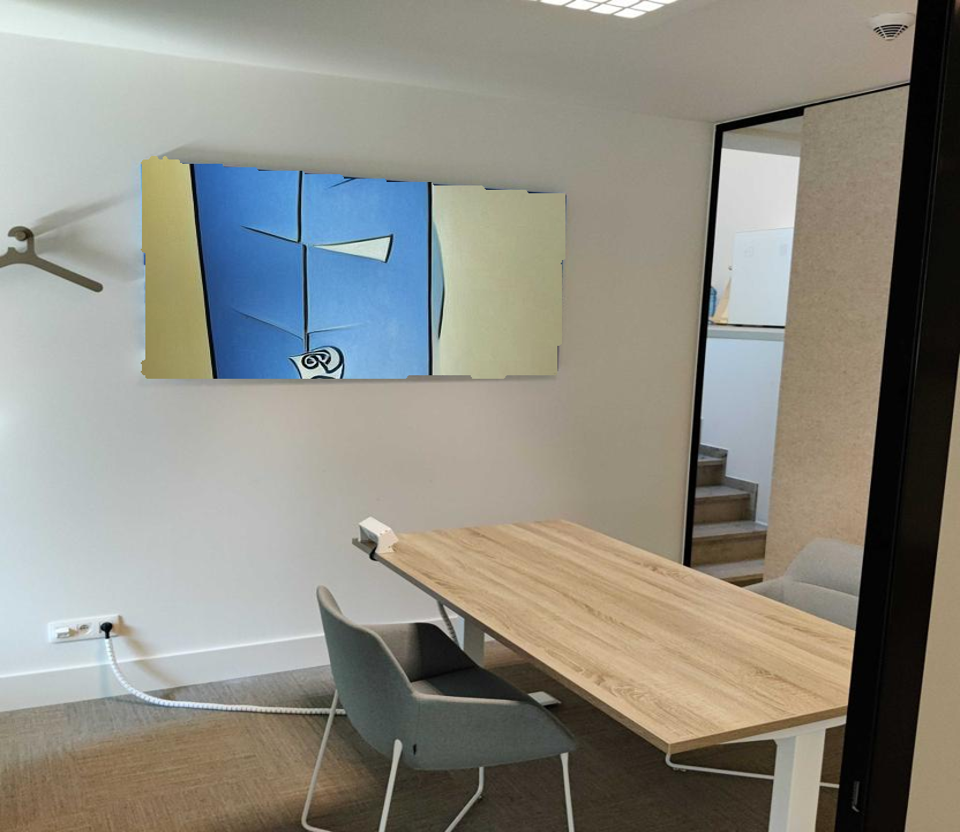

In [9]:
#@markdown ### Apply style only on the chosen object
#@markdown The last step of this exercise session is to apply the new style only on the wallframe and not on the entire picture using the mask determined in the previous section.
content_image = "image_to_custom.jpg"
generated_image = "image_to_custom_stylized_style_customized.jpg"
content_mask = "mask.jpg"

import os
import numpy as np
import imageio
from PIL import Image as Img
from PIL import ImageTk

# util function to load masks
def load_mask(mask_path, shape):
    mask = imageio.imread(mask_path, pilmode="L") # Grayscale mask load
    width, height, _ = shape
    mask = np.array(Img.fromarray(mask).resize((width, height))).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask

# util function to apply mask to generated image
def mask_content(content, generated, mask):
    generated = np.transpose(generated, (1, 0, 2))
    height, width, channels = generated.shape

    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    generated = np.array(Img.fromarray(generated).resize((content.shape[0], content.shape[1])))
    return generated
  
# util function to generate the final masked image
def save_final_masked(content_image, generated_image, content_mask):
  image_path = os.path.splitext(generated_image)[0] + "_masked.png"

  generated_image = imageio.imread(generated_image, pilmode="RGB")
  img_width, img_height, channels = generated_image.shape

  content_image = imageio.imread(content_image, pilmode='RGB')
  content_image = np.array(Img.fromarray(content_image).resize((img_width, img_height)))

  mask = load_mask(content_mask, generated_image.shape)

  img = mask_content(content_image, generated_image, mask)
  imageio.imwrite(image_path, img)

  return image_path

save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

# Let's look at the final styled image
from IPython.display import Image, display
display(Image(filename="image_to_custom_stylized_style_customized_masked.png"))

**Satisfied with your customization? Upload your final picture on [GCP](https://console.cloud.google.com/storage/browser/home_design_bucket/results?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&project=bootcamp-227610&prefix=&forceOnObjectsSortingFiltering=false) in the "results" folder!**

Note: The name of your file should contain your firstname and lastname. You can also upload the picture you used to build this amazing customization!